#Tarea: K-means

# Nombre: Isaac Cueva

# Fecha: 03/06/2025

![Descripción de la imagen](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRP9d63jC144Usqa_NjecnoWcJXV60JuFTJLA&s)

Sesión de Spark

In [1]:
# Installing required packages
!pip install pyspark
!pip install findspark

In [2]:
# PySpark is the Spark API for Python. In this lab, we use PySpark to initialize the spark context.
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
# Provides findspark.init() to make pyspark importable as a regular library.
import findspark
findspark.init()

In [3]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("k-means") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
spark

#TAREAS

Los datos del dataser adjunto son datos de varios sensores climáticos de una región de California en USA.

Su tarea consiste en encontrar patrones de zonas climáticas en los datos, para lo cual deberá usar k-means.

1. Verifique que no existen datos vacíos en el dataset.

In [5]:
file_path = "sample_minute_weather_processed.csv"

# Cargar el csv en un DataFrame de Spark
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Mostrar esquema y primeras filas para entender los datos
df.printSchema()
df.show(5)

root
 |-- air_pressure: double (nullable = true)
 |-- air_temp: double (nullable = true)
 |-- avg_wind_direction: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)
 |-- max_wind_direction: double (nullable = true)
 |-- max_wind_speed: double (nullable = true)
 |-- min_wind_direction: double (nullable = true)
 |-- min_wind_speed: double (nullable = true)
 |-- relative_humidity: double (nullable = true)

+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+
|air_pressure|air_temp|avg_wind_direction|avg_wind_speed|max_wind_direction|max_wind_speed|min_wind_direction|min_wind_speed|relative_humidity|
+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+
|       915.0|   80.24|             211.0|           1.5|             231.0|           2.0|             196.0|           1.1|             41.

In [6]:
from pyspark.sql.functions import col, sum

# Contar valores nulos por columna
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()


+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+
|air_pressure|air_temp|avg_wind_direction|avg_wind_speed|max_wind_direction|max_wind_speed|min_wind_direction|min_wind_speed|relative_humidity|
+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+
|           0|       0|                 0|             0|                 0|             0|                 0|             0|                0|
+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+



2. Elimine outliers en cada una de las variables.

In [7]:
from pyspark.sql.functions import expr

def remove_outliers(df, columns):
    for c in columns:
        # Calcular Q1 y Q3
        quantiles = df.approxQuantile(c, [0.25, 0.75], 0.05)
        Q1 = quantiles[0]
        Q3 = quantiles[1]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        print(f"{c}: lower={lower_bound}, upper={upper_bound}")

        # Filtrar filas dentro de los límites
        df = df.filter((col(c) >= lower_bound) & (col(c) <= upper_bound))
    return df

cols = df.columns
df_no_outliers = remove_outliers(df, cols)

print(f"Original count: {df.count()}, After outliers removal: {df_no_outliers.count()}")


air_pressure: lower=909.65, upper=923.65
air_temp: lower=28.58, upper=94.82000000000001
avg_wind_direction: lower=-156.0, upper=436.0
avg_wind_speed: lower=-1.8499999999999994, upper=6.549999999999999
max_wind_direction: lower=-154.5, upper=449.5
max_wind_speed: lower=-1.8499999999999996, upper=7.35
min_wind_direction: lower=-70.0, upper=378.0
min_wind_speed: lower=-1.4499999999999995, upper=4.549999999999999
relative_humidity: lower=-30.699999999999996, upper=120.5
Original count: 317365, After outliers removal: 272215


3. Normalice cada una de las variables.

In [8]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Paso 1: Armar vector con todas las columnas (variables)
assembler = VectorAssembler(inputCols=cols, outputCol="features_unscaled")
df_vector = assembler.transform(df_no_outliers)

# Paso 2: Normalizar
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

# Mostrar una fila para ver cómo quedó
df_scaled.select("features").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                         |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-0.700281853670598,1.4832819245745292,0.4792240280147222,-0.521381218896773,0.7013433911143059,-0.4589843790065022,0.2531121658258084,-0.48524375140781023,-0.22584650643801488]|
|[2.2603894478354185,-0.727081946725116,1.4961140193531695,-1.0541666156773768,1.6510339158182445,-0.9118138110100285,1.1635792007597086,-1.0180867618259828,-1.2224126974707576] |
|[-0.09296466361806964,0.5991363760546712,0.24297685830983037,1.1530871709851247,0.2792587134681109,

4. Encuente el valor óptimo de k.

k=2, WSSSE=1877890.3471403546
k=3, WSSSE=1533858.885801246
k=4, WSSSE=1400709.3863571056
k=5, WSSSE=1240982.8777166281
k=6, WSSSE=1163047.647256968
k=7, WSSSE=1043132.171550272
k=8, WSSSE=1006290.9906110934
k=9, WSSSE=927282.7160694213
k=10, WSSSE=875982.325414077


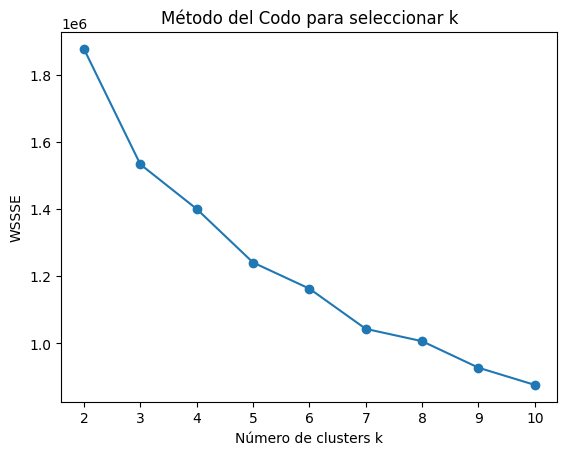

In [9]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

wssse_list = []

for k in range(2, 11):
    kmeans = KMeans(featuresCol="features", k=k, seed=1)
    model = kmeans.fit(df_scaled)
    wssse = model.summary.trainingCost
    print(f"k={k}, WSSSE={wssse}")
    wssse_list.append(wssse)

# Graficar
plt.plot(range(2, 11), wssse_list, marker='o')
plt.xlabel('Número de clusters k')
plt.ylabel('WSSSE')
plt.title('Método del Codo para seleccionar k')
plt.show()


- En base al gráfico podemos observar que el codo más óptimo es el k=4, con este valor podemos continuar con el entrenamiento del modelo.


5. Entrene un modelo de k-means con el valor óptimo de k y realice la predicción de etiquetas de los clusters.

In [14]:
k_opt = 4
kmeans = KMeans(featuresCol="features", k=k_opt, seed=1)
model = kmeans.fit(df_scaled)

# Realizar predicción de clusters
predictions = model.transform(df_scaled)

# Mostrar algunas filas con sus clusters asignados
predictions.select("features", "prediction").show(5)


+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-0.7002818536705...|         1|
|[2.26038944783541...|         1|
|[-0.0929646636180...|         2|
|[-1.5733003143710...|         1|
|[0.89392577021728...|         1|
+--------------------+----------+
only showing top 5 rows



6. Evalue los clusters con WSSSE y Siluotte Score. Interprete los resultados.

In [11]:
from pyspark.ml.evaluation import ClusteringEvaluator

# WSSSE
wssse = model.summary.trainingCost
print(f"WSSSE para k={k_opt}: {wssse}")

# Evaluar con Silhouette Score
evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='prediction', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score para k={k_opt}: {silhouette}")


WSSSE para k=4: 1400709.3863571056
Silhouette Score para k=4: 0.39186958844536907


7. Realice 5 gráficos de dispersión de dos dimensiones que permitan visualizar los clusters. Usted escoja la combinación de variables en cada gráfico.

Combinaciones elegidas:

- air_temp vs relative_humidity

- air_pressure vs air_temp

- avg_wind_speed vs max_wind_speed

- avg_wind_direction vs min_wind_direction

- relative_humidity vs air_pressure

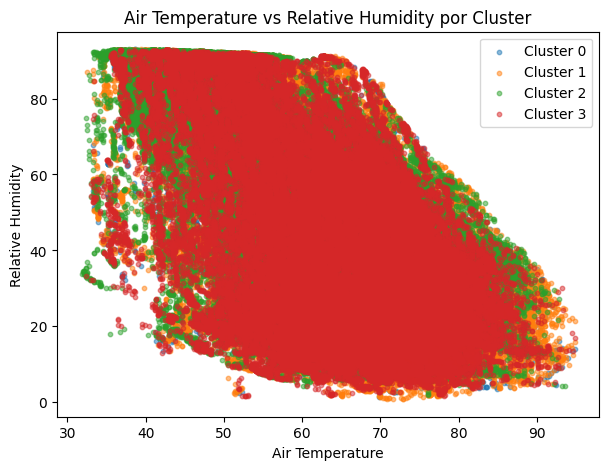

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


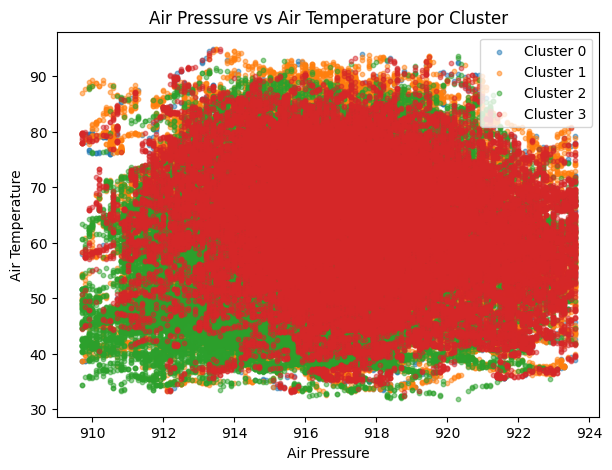

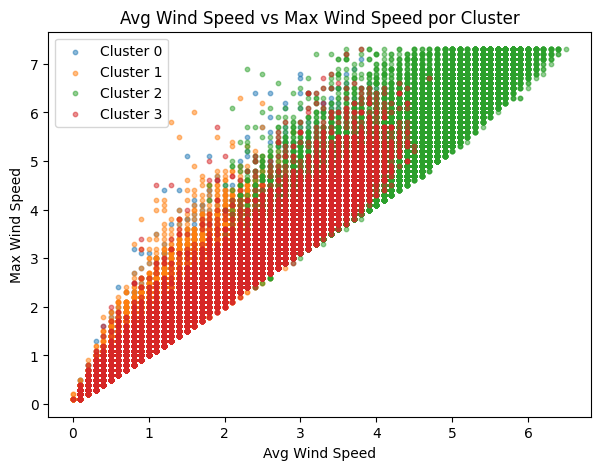

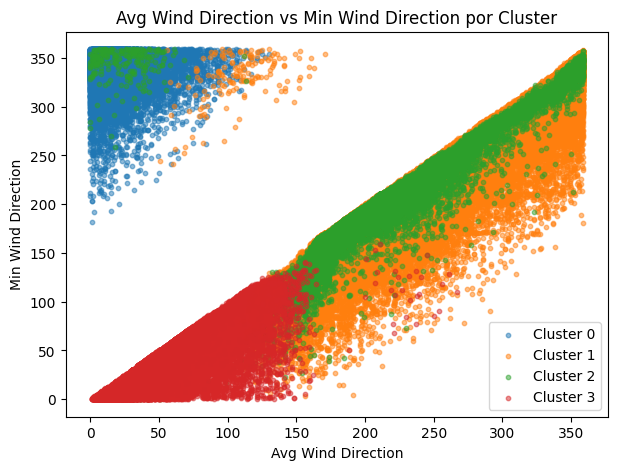

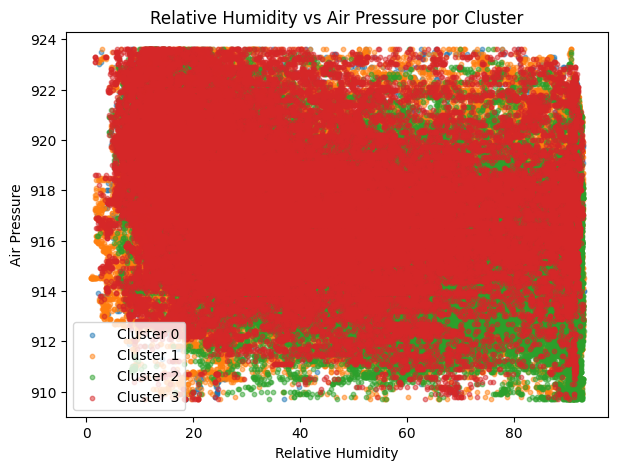

In [15]:
import matplotlib.pyplot as plt

# Tomar columnas originales + prediction en un pandas dataframe
pandas_df = predictions.select(
    "air_temp", "relative_humidity", "air_pressure",
    "avg_wind_speed", "max_wind_speed",
    "avg_wind_direction", "min_wind_direction",
    "prediction"
).toPandas()

# Función para graficar
def scatter_plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(7,5))
    for cluster in sorted(pandas_df['prediction'].unique()):
        subset = pandas_df[pandas_df['prediction'] == cluster]
        plt.scatter(subset[x], subset[y], label=f'Cluster {cluster}', alpha=0.5, s=10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(f'{xlabel} vs {ylabel} por Cluster')
    plt.show()

# Graficar las 5 combinaciones
scatter_plot('air_temp', 'relative_humidity', 'Air Temperature', 'Relative Humidity')
scatter_plot('air_pressure', 'air_temp', 'Air Pressure', 'Air Temperature')
scatter_plot('avg_wind_speed', 'max_wind_speed', 'Avg Wind Speed', 'Max Wind Speed')
scatter_plot('avg_wind_direction', 'min_wind_direction', 'Avg Wind Direction', 'Min Wind Direction')
scatter_plot('relative_humidity', 'air_pressure', 'Relative Humidity', 'Air Pressure')


Los clusters representan patrones climáticos distintos basados en todas las variables, pero en gráficos 2D algunos clusters grandes pueden dominar la visualización, causando superposiciones y mezclas visuales.

8. Reducción de Dimensionalidad - PCA

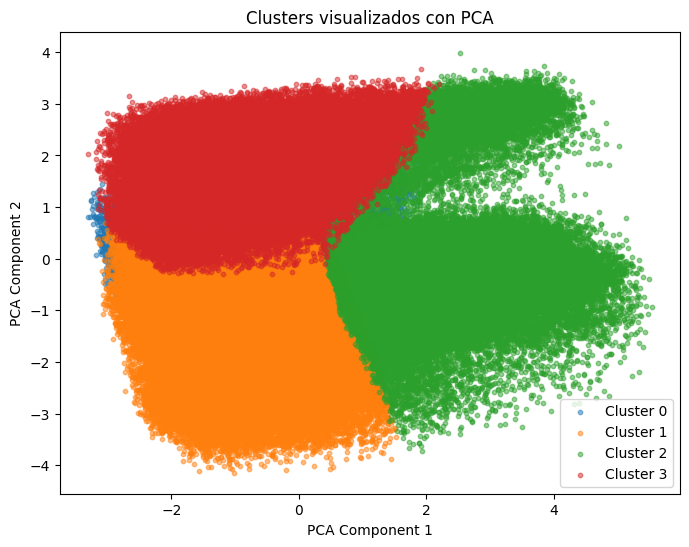

In [16]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

# Crear PCA para reducir a 2 componentes principales
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

# Añadir predicción de clusters (usamos el modelo k=4 que ya entrenamos)
predictions_pca = model.transform(df_pca)

# Convertir a pandas para graficar
pandas_pca = predictions_pca.select("pca_features", "prediction").toPandas()

# Extraer componentes para graficar
pandas_pca['pca1'] = pandas_pca['pca_features'].apply(lambda x: x[0])
pandas_pca['pca2'] = pandas_pca['pca_features'].apply(lambda x: x[1])

# Graficar PCA con clusters
plt.figure(figsize=(8,6))
for cluster in sorted(pandas_pca['prediction'].unique()):
    subset = pandas_pca[pandas_pca['prediction'] == cluster]
    plt.scatter(subset['pca1'], subset['pca2'], label=f'Cluster {cluster}', alpha=0.5, s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters visualizados con PCA')
plt.legend()
plt.show()
